<a href="https://colab.research.google.com/github/Offliners/HTML_2021Fall/blob/main/Final%20Project/HTML2021_Fall_svm_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Directory**

```
data_dir
    ├── data
    │   ├── Test_IDs.csv
    │   ├── ...
    │   ├── status.csv
    ├── statistics
    │   ├── Churn Category_stat.png
    │   ├── ...
    │   ├── miss rate_stat.png
```

# **Display information of GPU**

In [1]:
!nvidia-smi

Wed Jan 12 12:19:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Download Dataset**

In [2]:
!mkdir "./data"
!mkdir "./statistics"
!gdown --id 1X5yz7QLAu4nttnCea4ALf6alae6Clv_o --output "./data/dataset.zip"
!unzip -q "./data/dataset.zip" -d "./data"
!rm "./data/dataset.zip"

Downloading...
From: https://drive.google.com/uc?id=1X5yz7QLAu4nttnCea4ALf6alae6Clv_o
To: /content/data/dataset.zip
100% 660k/660k [00:00<00:00, 41.3MB/s]


# **Import Some Packages**

In [48]:
import time
import numpy as np
import pandas as pd
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report
from imblearn.over_sampling import ADASYN
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary

# **Set a Random Seed**

In [34]:
# Set a random seed for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# **CSV Files Combination**

In [5]:
train_path = './data/Train_IDs.csv'  # path to training data
test_path = './data/Test_IDs.csv'    # path to testing data

files = glob('./data/*.csv')
data_csv = []
data_csv.append(train_path)
for csv in files:
    if ('IDs' not in csv) and ('sample' not in csv) and ('population' not in csv) and ('result' not in csv):
        data_csv.append(csv)
  
print(data_csv)
df_list = [pd.read_csv(file) for file in data_csv]

['./data/Train_IDs.csv', './data/services.csv', './data/status.csv', './data/satisfaction.csv', './data/demographics.csv', './data/location.csv']


In [6]:
result_total = df_list[0]
for df in df_list[1:]:
    result_total = pd.merge(result_total, df, how='outer', on='Customer ID')

result_total.to_csv('./data/result_total.csv') # Save combined all result to result_total.csv

In [7]:
# There are 7043 total customer data
print(result_total)

     Customer ID  Count_x  ...   Latitude   Longitude
0     0650-BWOZN      1.0  ...        NaN         NaN
1     0562-FGDCR      1.0  ...  34.903052 -118.411251
2     6688-UZPWD      1.0  ...  33.721917 -118.043237
3     2905-KFQUV      1.0  ...        NaN -122.000887
4     9720-JJJOR      1.0  ...  39.672813 -120.456699
...          ...      ...  ...        ...         ...
7038  6485-QXWWE      NaN  ...        NaN -118.149953
7039  9408-SSNVZ      NaN  ...  33.818477 -118.038307
7040  3426-NIYYL      NaN  ...        NaN         NaN
7041  8231-BSWXX      NaN  ...  34.097863 -116.594561
7042  4482-EWFMI      NaN  ...        NaN -120.132870

[7043 rows x 48 columns]


In [8]:
# Train_IDs has 5634 customer data
result_train = df_list[0]
for df in df_list[1:]:
    result_train = pd.merge(result_train, df, how='left', on='Customer ID')

print(result_train)

     Customer ID  Count_x  ...   Latitude   Longitude
0     0650-BWOZN      1.0  ...        NaN         NaN
1     0562-FGDCR      1.0  ...  34.903052 -118.411251
2     6688-UZPWD      1.0  ...  33.721917 -118.043237
3     2905-KFQUV      1.0  ...        NaN -122.000887
4     9720-JJJOR      1.0  ...  39.672813 -120.456699
...          ...      ...  ...        ...         ...
5629  1178-PZGAB      1.0  ...        NaN         NaN
5630  4806-KEXQR      1.0  ...  37.140104 -119.657092
5631  8809-RIHDD      1.0  ...        NaN         NaN
5632  6663-JOCQO      1.0  ...        NaN         NaN
5633  7010-ZMVBF      1.0  ...  36.623632 -119.741322

[5634 rows x 48 columns]


In [9]:
# Test_Ids has 1409 customer data
df_test = pd.read_csv(test_path)
result_test = df_test
for df in df_list[1:]:
    result_test = pd.merge(result_test, df, how='left', on='Customer ID')

print(result_test)

     Customer ID  Count_x  ...   Latitude   Longitude
0     9938-EKRGF      1.0  ...  33.141265 -116.967221
1     7379-POKDZ      1.0  ...  34.231318 -117.662032
2     0654-HMSHN      1.0  ...  32.802959 -117.027095
3     2045-BMBTJ      1.0  ...        NaN         NaN
4     0701-TJSEF      1.0  ...  33.581045 -117.147190
...          ...      ...  ...        ...         ...
1404  4587-VVTOX      1.0  ...  37.871416         NaN
1405  7716-YTYHG      NaN  ...  40.448632         NaN
1406  7649-PHJVR      NaN  ...        NaN         NaN
1407  7855-DIWPO      1.0  ...  33.688546         NaN
1408  8197-BFWVU      1.0  ...  33.956445 -118.358634

[1409 rows x 48 columns]


In [10]:
print(result_total.dropna()) # Find customer with full data infomation

     Customer ID  Count_x  ...   Latitude   Longitude
666   0454-OKRCT      1.0  ...  38.425280 -119.475741
678   1735-XMJVH      1.0  ...  38.809175 -121.171375
1799  1245-HARPS      1.0  ...  40.587919 -122.464732
2805  8445-DNBAE      1.0  ...  41.212695 -122.392067
2883  8708-XPXHZ      1.0  ...  40.342928 -124.063329
3062  9522-ZSINC      1.0  ...  34.128284 -118.047732
4297  0836-SEYLU      1.0  ...  36.414611 -121.638600
5146  7274-RTAPZ      1.0  ...  36.657462 -119.595293

[8 rows x 48 columns]


In [11]:
result_cols = result_total.columns
print(result_cols)

Index(['Customer ID', 'Count_x', 'Quarter', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Churn Category', 'Satisfaction Score', 'Count_y',
       'Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married', 'Dependents',
       'Number of Dependents', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude'],
      dtype='object')


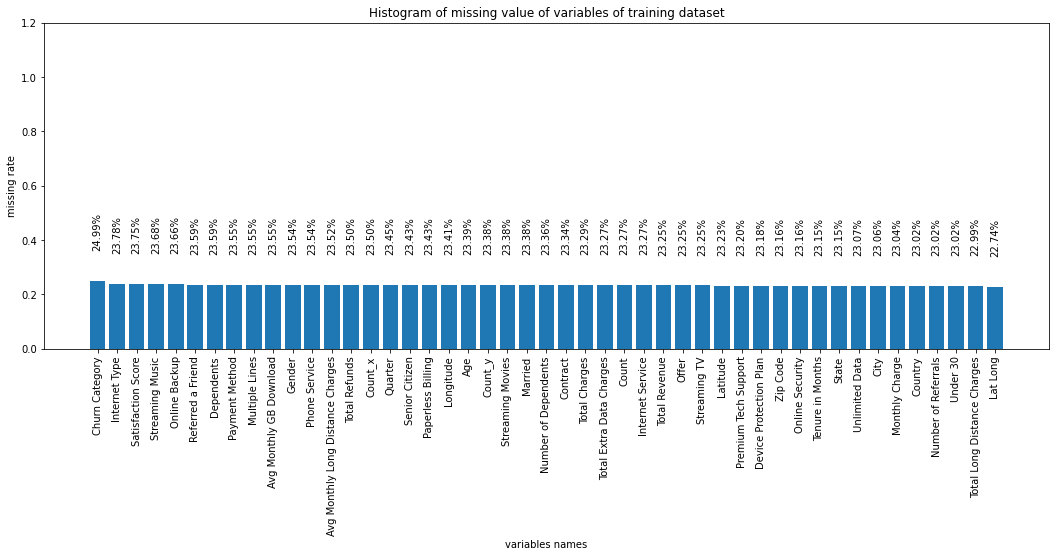

In [12]:
missing = result_train.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate'] = missing['missNum'] / result_train.shape[0]
miss_analy = missing[missing.missRate > 0].sort_values(by='missRate', ascending=False)

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align='center')

plt.title('Histogram of missing value of variables of training dataset')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]), list(miss_analy['index']))
plt.xticks(rotation=90)
for x, y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x, y + 0.12, '{:.2%}'.format(y), ha='center', rotation=90)    

plt.ylim([0, 1.2])  
plt.savefig(f'./statistics/miss rate_train_stat.png')  
plt.show()
plt.close()

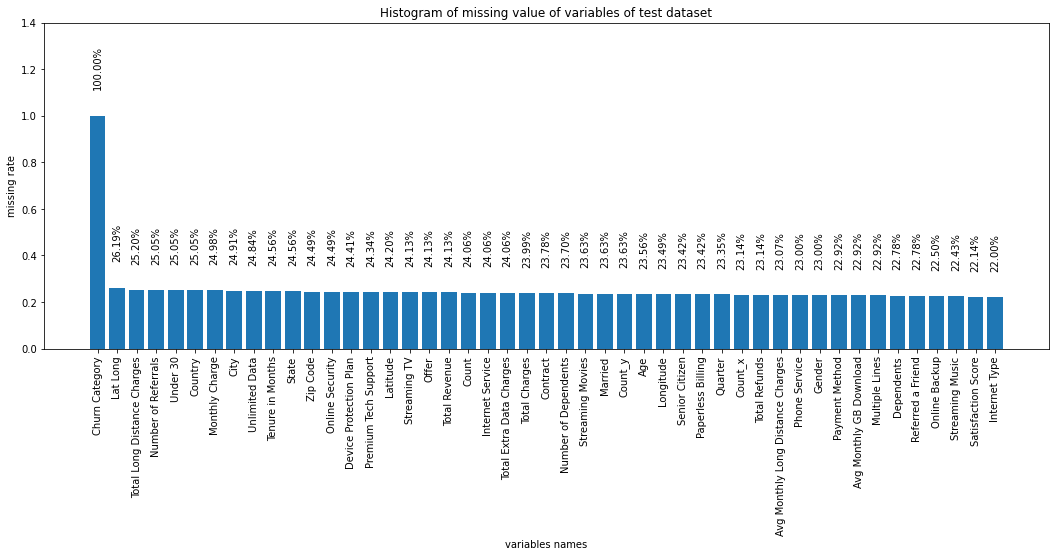

In [13]:
missing = result_test.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate'] = missing['missNum'] / result_test.shape[0]
miss_analy = missing[missing.missRate > 0].sort_values(by='missRate', ascending=False)

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align='center')

plt.title('Histogram of missing value of variables of test dataset')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]), list(miss_analy['index']))
plt.xticks(rotation=90)
for x, y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x, y + 0.12, '{:.2%}'.format(y), ha='center', rotation=90)    

plt.ylim([0, 1.4])  
plt.savefig(f'./statistics/miss rate_test_stat.png')  
plt.show()
plt.close()

# **Statistics and Data Preprocessing**

In [14]:
result_train_copy = result_train.copy(deep=True)
result_test_copy = result_test.copy(deep=True)
def label_statistics(label):
    freq = result_train.groupby(label).size() 

    names = [name for name, _ in freq.items()]
    counts = [count for _, count in freq.items()]

    fig = plt.figure(figsize=(8, 6))
    x = np.arange(len(names))
    plt.bar(x, counts)
    plt.xticks(x, names, rotation=15)
    plt.title(f'Statistics of {label}')
    plt.savefig(f'./statistics/Statistics of {label}.png')
    print(f'Statistics of {label}.png saved')
    plt.close()

    # Replace NaN with random choice label with the original distribution
    probability = [p / np.sum(counts) for p in counts]
    result_train_copy[label] = result_train_copy[label].apply(lambda x: np.random.choice(names, p=probability) if pd.isnull(x) else x)
    result_test_copy[label] = result_test_copy[label].apply(lambda x: np.random.choice(names, p=probability) if pd.isnull(x) else x)

In [15]:
need_statistics_col = ['Churn Category', 'Satisfaction Score', 
       'Gender', 'Under 30', 'Senior Citizen', 'Married', 'Dependents',
       'Number of Dependents', 'Country', 'State', 'City', 'Quarter',
       'Referred a Friend', 'Number of Referrals', 'Offer',
       'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method']

# Replace NaN with the most frequent label
for need_col in need_statistics_col:
    label_statistics(need_col)

    # Encode target labels with value
    le = LabelEncoder()
    result_train_copy[need_col] = le.fit_transform(result_train_copy[need_col])
    result_test_copy[need_col] = le.fit_transform(result_test_copy[need_col])

    if need_col == 'Churn Category':
        encoder_map = dict(zip(le.classes_, le.transform(le.classes_)))

Statistics of Churn Category.png saved
Statistics of Satisfaction Score.png saved
Statistics of Gender.png saved
Statistics of Under 30.png saved
Statistics of Senior Citizen.png saved
Statistics of Married.png saved
Statistics of Dependents.png saved
Statistics of Number of Dependents.png saved
Statistics of Country.png saved
Statistics of State.png saved
Statistics of City.png saved
Statistics of Quarter.png saved
Statistics of Referred a Friend.png saved
Statistics of Number of Referrals.png saved
Statistics of Offer.png saved
Statistics of Phone Service.png saved
Statistics of Multiple Lines.png saved
Statistics of Internet Service.png saved
Statistics of Internet Type.png saved
Statistics of Online Security.png saved
Statistics of Online Backup.png saved
Statistics of Device Protection Plan.png saved
Statistics of Premium Tech Support.png saved
Statistics of Streaming TV.png saved
Statistics of Streaming Movies.png saved
Statistics of Streaming Music.png saved
Statistics of Unlimi

In [16]:
need_avg_col = [item for item in result_cols if item not in need_statistics_col]

# Replace NaN with median value or 0
for avg_col in need_avg_col[1:]:
    if avg_col == 'Zip Code' or avg_col == 'Lat Long':
        continue
    elif 'Count' in avg_col:
        result_train_copy[avg_col] = result_train_copy[avg_col].fillna(0)
        result_test_copy[avg_col] = result_test_copy[avg_col].fillna(0)
    else:
        result_train_copy[avg_col] = result_train_copy[avg_col].fillna(result_train_copy[avg_col].median()) 
        result_test_copy[avg_col] = result_test_copy[avg_col].fillna(result_train_copy[avg_col].median())

In [17]:
# Find the correlation of columns
cor_matrix = result_train_copy.corr().abs()
print(cor_matrix['Churn Category'])

Count_x                              0.001317
Quarter                                   NaN
Referred a Friend                    0.039161
Number of Referrals                  0.081623
Tenure in Months                     0.124967
Offer                                0.064084
Phone Service                        0.007903
Avg Monthly Long Distance Charges    0.012097
Multiple Lines                       0.025724
Internet Service                     0.093695
Internet Type                        0.041499
Avg Monthly GB Download              0.040774
Online Security                      0.057228
Online Backup                        0.013486
Device Protection Plan               0.003886
Premium Tech Support                 0.065226
Streaming TV                         0.011442
Streaming Movies                     0.038226
Streaming Music                      0.020193
Unlimited Data                       0.069493
Contract                             0.137617
Paperless Billing                 

In [18]:
def dropColumns(label):
    global result_train_copy, result_test_copy
    result_train_copy = result_train_copy.drop(label, axis=1)
    result_test_copy = result_test_copy.drop(label, axis=1)

In [19]:
# Throw away the data columns I think is useless
useless = ['Count_x', 'Count_y', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Count', 'Quarter']

for item in useless:
    dropColumns(item)

In [20]:
result_train_copy.to_csv('./data/result_after_preprocessing.csv') # Save after preprocessing result to result_after_preprocessing.csv

print(result_train_copy)
print(result_test_copy)

     Customer ID  Referred a Friend  ...  Dependents  Number of Dependents
0     0650-BWOZN                  0  ...           0                     0
1     0562-FGDCR                  0  ...           0                     0
2     6688-UZPWD                  1  ...           1                     0
3     2905-KFQUV                  0  ...           0                     0
4     9720-JJJOR                  1  ...           0                     0
...          ...                ...  ...         ...                   ...
5629  1178-PZGAB                  0  ...           0                     0
5630  4806-KEXQR                  0  ...           0                     0
5631  8809-RIHDD                  0  ...           1                     2
5632  6663-JOCQO                  0  ...           1                     3
5633  7010-ZMVBF                  1  ...           0                     0

[5634 rows x 37 columns]
     Customer ID  Referred a Friend  ...  Dependents  Number of Dependents

# **Train**

In [88]:
y_train = result_train_copy['Churn Category'].values
X_train = result_train_copy.drop('Customer ID', axis=1)
X_train = X_train.drop('Churn Category', axis=1)

In [89]:
print(f"normal data distribution: {Counter(y_train)}")

smo = ADASYN(random_state=seed)
X_train, y_train = smo.fit_resample(X_train, y_train)

print(f"SMOTE data distribution: {Counter(y_train)}")

normal data distribution: Counter({3: 4133, 1: 662, 0: 271, 2: 222, 4: 175, 5: 171})
SMOTE data distribution: Counter({5: 4185, 2: 4172, 3: 4133, 4: 4132, 1: 4120, 0: 4054})


In [82]:
sc = StandardScaler()
ss = StandardScaler().fit(X_train)
X_train_std = ss.transform(X_train)
mms = MinMaxScaler(feature_range=(0, 1)).fit(X_train_std)
X_train_std = mms.transform(X_train_std)

# **SVM**

In [24]:
svm = SVC(kernel='rbf', gamma=0.7, C=10, decision_function_shape='ovr')

# SVM with class weight
# svm = SVC(kernel='rbf', gamma=0.7, class_weight={0:10, 1:10, 2:10, 3:1, 4:10, 5:10})

start_time = time.time()
model = svm.fit(X_train_std, y_train)
end_time = time.time()

print(f'Training use {round(end_time - start_time, 3)}s')

Training use 45.686s


In [25]:
y_train_predict = svm.predict(X_train_std)
Ein = np.mean(np.array(y_train_predict) != y_train)
F1in = metrics.f1_score(y_train, y_train_predict, average='macro')  
print(f'Ein = {round(Ein, 5)}')
print(f'F1_in = {round(F1in, 5)}')

Ein = 0.01391
F1_in = 0.98606


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}


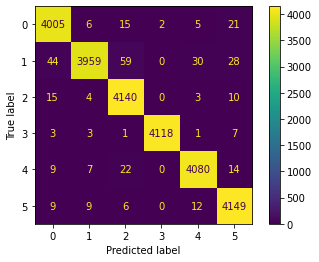

In [26]:
plot_confusion_matrix(model, X_train_std, y_train)
print(encoder_map)

In [27]:
print(classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4054
           1       0.99      0.96      0.98      4120
           2       0.98      0.99      0.98      4172
           3       1.00      1.00      1.00      4133
           4       0.99      0.99      0.99      4132
           5       0.98      0.99      0.99      4185

    accuracy                           0.99     24796
   macro avg       0.99      0.99      0.99     24796
weighted avg       0.99      0.99      0.99     24796



# **SVM Test**

In [28]:
X_test = result_test_copy.drop('Customer ID', axis=1)
X_test = X_test.drop('Churn Category', axis=1)
ss = StandardScaler().fit(X_test)
X_test_std = ss.transform(X_test)
mms = MinMaxScaler(feature_range=(0, 1)).fit(X_test_std)
X_test_std = mms.transform(X_test_std)
y_test = svm.predict(X_test_std)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}


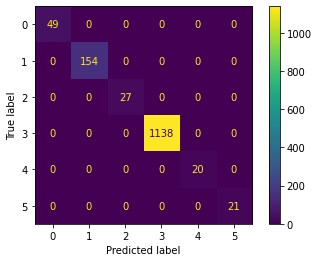

In [29]:
plot_confusion_matrix(model, X_test_std, y_test)
print(encoder_map)

In [30]:
submit_result = './svm_result.csv'

new_encoder_map = {'No Churn':0, 'Competitor': 1, 'Dissatisfaction':2, 'Attitude': 3, 'Price':4, 'Other':5}

with open(submit_result, 'w') as f:
    f.write('Customer ID,Churn Category\n')
    for i in range(len(df_test.values)):
        id = str(df_test.values[i]).replace('[\'', '')
        id = id.replace('\']', '')
        pred = new_encoder_map.get(list(encoder_map.keys())[list(encoder_map.values()).index(y_test[i])])
        f.write(f'{id},{pred}\n')

In [118]:
from google.colab import files

files.download(submit_result)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Deep Neural Network**

In [90]:
class IBMDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

In [91]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(35, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 6) 
        self.act_fn = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.act_fn(x)
        x = self.layer2(x)
        x = self.act_fn(x)
        x = self.layer3(x)
        x = self.act_fn(x)
        x = self.out(x)
        
        return x

classifier = Classifier()
summary(classifier, X_train.shape, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 24796, 512]          18,432
           Sigmoid-2           [-1, 24796, 512]               0
            Linear-3           [-1, 24796, 256]         131,328
           Sigmoid-4           [-1, 24796, 256]               0
            Linear-5           [-1, 24796, 128]          32,896
           Sigmoid-6           [-1, 24796, 128]               0
            Linear-7             [-1, 24796, 6]             774
Total params: 183,430
Trainable params: 183,430
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.31
Forward/backward pass size (MB): 340.14
Params size (MB): 0.70
Estimated Total Size (MB): 344.15
----------------------------------------------------------------


In [92]:
VAL_RATIO = 0.2
BATCH_SIZE = 64

percent = int(X_train.shape[0] * (1 - VAL_RATIO))
X_train = X_train.values
train_x, train_y, val_x, val_y = X_train[:percent], y_train[:percent], X_train[percent:], y_train[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (19836, 35)
Size of validation set: (4960, 35)


In [93]:
train_set = IBMDataset(train_x, train_y)
val_set = IBMDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) # only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

In [94]:
# get device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

# training parameters
num_epoch = 3000             # number of training epoch
learning_rate = 0.0001       # learning rate

# the path where checkpoint saved
model_path = './best_model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cuda


In [95]:
best_acc = 0.0
start_time = time.time()
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # training
    model.train() # set the model to training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward() 
        optimizer.step() 

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels) 
                _, val_pred = torch.max(outputs, 1) 
            
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')

end_time = time.time()

[001/3000] Train Acc: 0.224239 Loss: 1.658367 | Val Acc: 0.000000 loss: 3.794760
[002/3000] Train Acc: 0.246421 Loss: 1.630245 | Val Acc: 0.000000 loss: 3.987758
[003/3000] Train Acc: 0.268754 Loss: 1.610965 | Val Acc: 0.000000 loss: 4.000502
[004/3000] Train Acc: 0.292347 Loss: 1.592151 | Val Acc: 0.000000 loss: 3.992181
[005/3000] Train Acc: 0.306715 Loss: 1.573729 | Val Acc: 0.000000 loss: 4.087987
[006/3000] Train Acc: 0.323654 Loss: 1.554366 | Val Acc: 0.000000 loss: 4.067157
[007/3000] Train Acc: 0.338677 Loss: 1.534961 | Val Acc: 0.000000 loss: 4.116709
[008/3000] Train Acc: 0.353045 Loss: 1.510781 | Val Acc: 0.001411 loss: 4.123823
saving model with acc 0.001
[009/3000] Train Acc: 0.375176 Loss: 1.487714 | Val Acc: 0.010484 loss: 4.106392
saving model with acc 0.010
[010/3000] Train Acc: 0.385763 Loss: 1.462513 | Val Acc: 0.014315 loss: 4.172632
saving model with acc 0.014
[011/3000] Train Acc: 0.398165 Loss: 1.436156 | Val Acc: 0.019355 loss: 4.092817
saving model with acc 0.0

In [110]:
print(f'Training use {round(end_time - start_time, 3)}s')

Training use 2951.117s


In [112]:
# create testing dataset
test_set = IBMDataset(X_test.values, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [113]:
predict = []
model.eval() # set the model to evaluation mode
for i, data in enumerate(test_loader):
    inputs = data
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

    for y in test_pred.cpu().numpy():
        predict.append(y)

In [117]:
submit_result = './dnn_result.csv'

new_encoder_map = {'No Churn':0, 'Competitor': 1, 'Dissatisfaction':2, 'Attitude': 3, 'Price':4, 'Other':5}

with open(submit_result, 'w') as f:
    f.write('Customer ID,Churn Category\n')
    for i in range(len(df_test.values)):
        id = str(df_test.values[i]).replace('[\'', '')
        id = id.replace('\']', '')
        pred = new_encoder_map.get(list(encoder_map.keys())[list(encoder_map.values()).index(predict[i])])
        f.write(f'{id},{pred}\n')

In [ ]:
from google.colab import files

files.download(submit_result)